In [8]:
!nvidia-smi

Wed Aug 20 04:30:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.148.08             Driver Version: 570.148.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GH200 480GB             On  |   00000000:DD:00.0 Off |                    0 |
| N/A   34C    P0             68W /  700W |       4MiB /  97871MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [9]:
import os

HOME = os.getcwd()
print("HOME:", HOME)

HOME: /lambda/nfs/droneforge-synthetic-uavs/projects/synthetic_drone_swarm_sim


## Install dependencies

In [10]:
!pip install -q ultralytics supervision trackers==2.0.2rc0

### Download video + weights

In [11]:
!wget -q https://raw.githubusercontent.com/droneforge/yolov11n-UAV-finetune/main/yolov11n-UAV-finetune.pt
!wget -q https://raw.githubusercontent.com/droneforge/yolov11n-UAV-finetune/main/anduril_swarm.mp4

In [6]:
!gunzip -k yolo12l-UAV-finetune.pt.gz

In [12]:
from pathlib import Path

SOURCE_VIDEO_PATH = Path(HOME) / "infer_vids/anduril_swarm.mp4"
SOURCE_VIDEO_PATH_2 = Path(HOME) / "infer_vids/swarm_bg_terrain1/swarm_bg_terrain1.mp4"
SOURCE_WEIGHTS_PATH = Path(HOME) / "yolo12l-UAV-finetune.pt"

## Load model

In [13]:
import supervision as sv
from ultralytics import YOLO

MODEL = YOLO(SOURCE_WEIGHTS_PATH)

COLOR = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

### Load challenging video frame (lots of small objects)

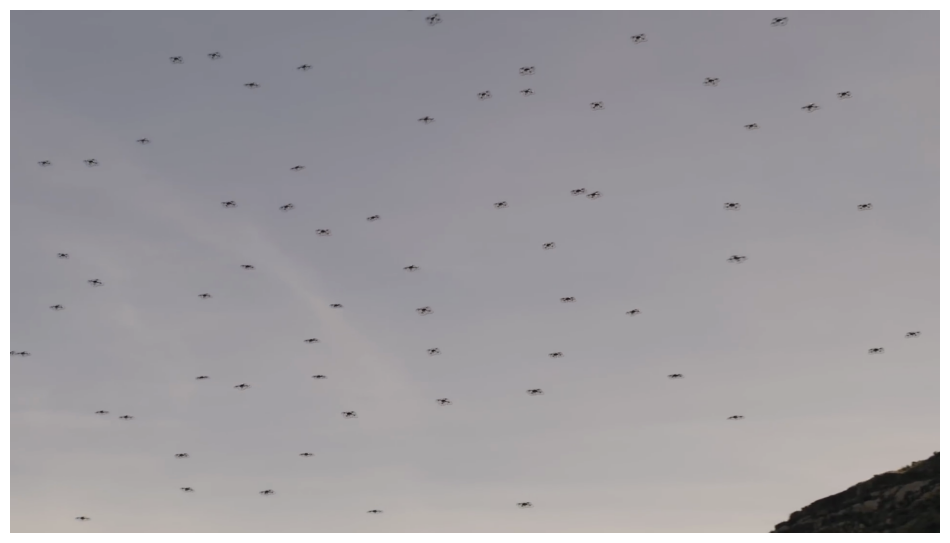

In [14]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=390, iterative_seek=True)
frame = next(frame_generator)

sv.plot_image(frame)

### Single-frame inference at 640px

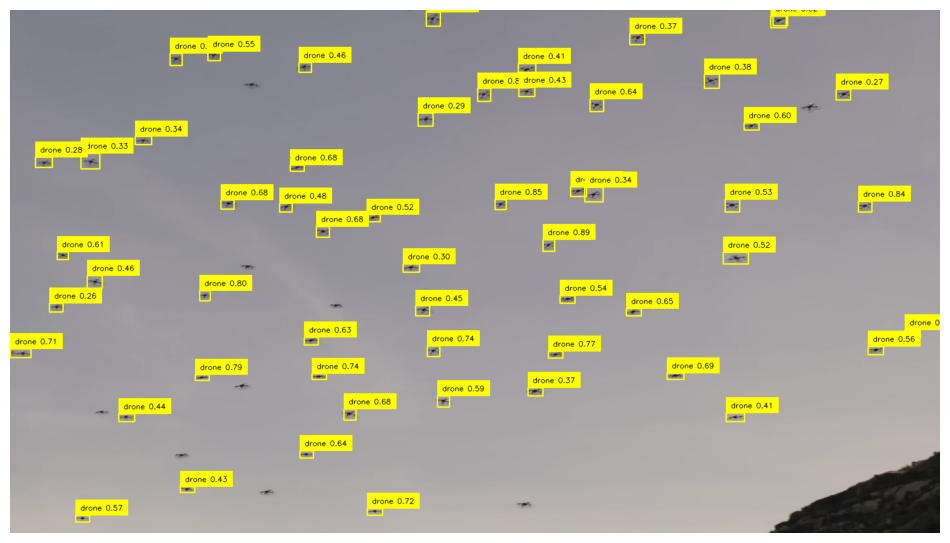

In [16]:
box_annotator = sv.BoxAnnotator(color=COLOR, thickness=2)
label_annotator = sv.LabelAnnotator(color=COLOR, text_color=sv.Color.BLACK)

result = MODEL(frame, verbose=False)[0]
detections = sv.Detections.from_ultralytics(result)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)

### Single-frame inference at 640px with InferenceSlicer

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


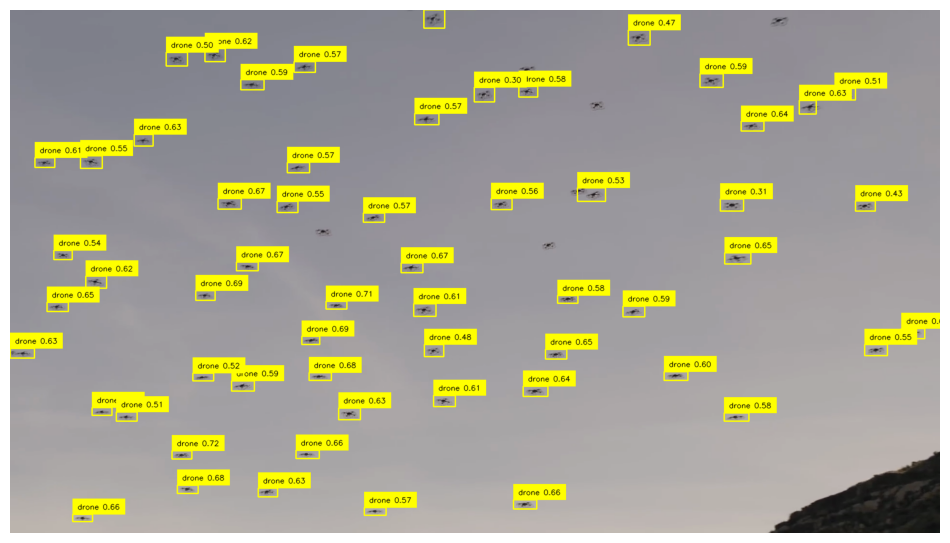

In [17]:
import numpy as np

box_annotator = sv.BoxAnnotator(color=COLOR, thickness=2)
label_annotator = sv.LabelAnnotator(color=COLOR, text_color=sv.Color.BLACK)

def callback(image_slice: np.ndarray) -> sv.Detections:
    result = MODEL(image_slice, verbose=False)[0]
    return sv.Detections.from_ultralytics(result)

slicer = sv.InferenceSlicer(callback = callback, slice_wh = (640, 640))
detections = slicer(frame)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)

### Full-video inference at 640px with InferenceSlicer and Trackers

In [ ]:
import numpy as np
from trackers import SORTTracker

tracker = SORTTracker()

src_vid_path = SOURCE_VIDEO_PATH_2

TARGET_VIDEO_PATH = src_vid_path.parent / f"{src_vid_path.stem}-result{src_vid_path.suffix}"
TARGET_VIDEO_PATH_COMPRESSED = TARGET_VIDEO_PATH.parent / f"{TARGET_VIDEO_PATH.stem}-compressed{TARGET_VIDEO_PATH.suffix}"

box_annotator = sv.BoxAnnotator(color=COLOR, thickness=2, color_lookup=sv.ColorLookup.TRACK)
label_annotator = sv.LabelAnnotator(color=COLOR, text_color=sv.Color.BLACK, color_lookup=sv.ColorLookup.TRACK)

def slicer_callback(image_slice: np.ndarray) -> sv.Detections:
    result = MODEL(image_slice, conf=0.10, verbose=False)[0]
    return sv.Detections.from_ultralytics(result)

slicer = sv.InferenceSlicer(callback = slicer_callback, slice_wh = (640, 640), iou_threshold=0.3)

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    detections = slicer(frame)
    detections = detections[detections.area < 2000]
    detections = tracker.update(detections)

    if len(detections) == 0:
        return frame

    labels = [
        f"{class_name} {confidence:.2f}"
        for class_name, confidence
        in zip(detections['class_name'], detections.confidence)
    ]

    annotated_frame = frame.copy()
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels)
    return annotated_frame

sv.process_video(
    source_path=src_vid_path,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


In [ ]:
!ffmpeg -y -i "{TARGET_VIDEO_PATH}" -vcodec libx264 -crf 28 "{TARGET_VIDEO_PATH_COMPRESSED}"

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def display_video(path, width=1280):
    video_file = open(path, "rb").read()
    video_url = "data:video/mp4;base64," + b64encode(video_file).decode()
    return HTML(f"""
    <video width={width} controls>
        <source src="{video_url}" type="video/mp4">
    </video>
    """)

display_video(TARGET_VIDEO_PATH_COMPRESSED)